
## 1. Load Preprocessed Dataset
- Load the preprocessed train, validation, and test datasets.


In [2]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
from src.utils import visualization_utils as vu
from src.utils import dataset_utils as du


import tensorflow as tf
import tensorflow_datasets as tfds


# prevent TensorFlow from allocating all the GPU memory at the start
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

# Clear Keras session
import tensorflow.keras.backend as K
K.clear_session()

# Define data directories
base_dir = '/tf/projects/malaria-image-recognition/notebooks/'
data_dir = os.path.join(base_dir, 'data', 'raw')

# Load the dataset with TensorFlow Datasets without downloading
datasets, _info = tfds.load('malaria',
                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                            data_dir=data_dir,
                            shuffle_files=True,
                            download=True,  # Do not download the dataset again as already available in the localhost
                            as_supervised=True,
                            with_info=True)

train_dataset, val_dataset, test_dataset = datasets
# print(_info)

# Print five random samples
print('\n\n Random samples from train_dataset: \n\n')
du.print_sample_info(test_dataset)





 Random samples from train_dataset: 


Sample 1:
Image shape: (124, 142, 3)
Image size: 52824
Image dimensions: 3
Label: 0

Sample 2:
Image shape: (124, 127, 3)
Image size: 47244
Image dimensions: 3
Label: 0

Sample 3:
Image shape: (136, 127, 3)
Image size: 51816
Image dimensions: 3
Label: 1

Sample 4:
Image shape: (112, 118, 3)
Image size: 39648
Image dimensions: 3
Label: 1

Sample 5:
Image shape: (136, 118, 3)
Image size: 48144
Image dimensions: 3
Label: 1



2024-07-20 01:11:09.830245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Preprocess the dataset
train_dataset_preprocessed = du.preprocess_dataset(train_dataset, buffer_size=10000, batch_size=300)
val_dataset_preprocessed = du.preprocess_dataset(val_dataset, buffer_size=10000, batch_size=300)
test_dataset_preprocessed = du.preprocess_dataset(test_dataset, buffer_size=10000, batch_size=300)


In [5]:
# # After preprocessing
print("After preprocessing:")
print('\n\n Random samples from train_dataset after preprocessing:: \n\n')
du.print_sample_info(train_dataset_preprocessed)

After preprocessing:


 Random samples from train_dataset after preprocessing:: 




2024-07-20 01:14:10.469772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:100: Filling up shuffle buffer (this may take a while): 15 of 1000


Sample 1:
Image shape: (300, 128, 128, 3)
Image size: 14745600
Image dimensions: 4
Label: [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1
 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1
 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1
 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1
 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0
 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0
 1 0 0 1]

Sample 2:
Image shape: (300, 128, 128, 3)
Image size: 14745600
Image dimensions: 4
Label: [0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1
 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 

2024-07-20 01:14:20.599343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-20 01:14:20.619624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



## 2. Define LeNet Model
- Define the LeNet architecture using TensorFlow/Keras.


In [10]:
# Model architecture
# Model definition and compilation

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import BinaryAccuracy


def lenet_model():
    model = tf.keras.Sequential([

        InputLayer(shape=(128, 128, 3)),
        
        Conv2D(6, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(.15),
        
        Conv2D(16, (5, 5), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(.25),
        
        tf.keras.layers.Flatten(),
                
        tf.keras.layers.Dense(120, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        
        tf.keras.layers.Dense(84, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid') 
    ],
       name = 'CNN-malaria-detection'
   )

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy()])
    return model

model = lenet_model()
model.summary()

Model: "CNN-malaria-detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 124, 124, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 62, 62, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 58, 58, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │     1,614,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 120)            │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 84)             │           336 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,865 (6.21 MB)

 Trainable params: 1,628,413 (6.21 MB)

 Non-trainable params: 452 (1.77 KB)


## 4. Train Model
- Define necessary callbacks 
- Train the model on the training dataset.
- Validate the model on the validation dataset.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1  # Set verbose to 1 to print messages
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1  # Set verbose to 1 to print messages
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.01,
    verbose=1  # Set verbose to 1 to print messages
)

tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

# Fit the model with the callbacks
history = model.fit(
    train_dataset_preprocessed,
    epochs=20,
    verbose=1,
    validation_data=val_dataset_preprocessed,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard]
)


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - binary_accuracy: 0.6398 - loss: 0.7227
Epoch 1: val_loss improved from inf to 4.47709, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 71s 522ms/step - binary_accuracy: 0.6405 - loss: 0.7213 - val_binary_accuracy: 0.4888 - val_loss: 4.4771 - learning_rate: 0.0100
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - binary_accuracy: 0.8552 - loss: 0.3553
Epoch 2: val_loss improved from 4.47709 to 2.21106, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - binary_accuracy: 0.8556 - loss: 0.3544 - val_binary_accuracy: 0.6843 - val_loss: 2.2111 - learning_rate: 0.0100
Epoch 3/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - binary_accuracy: 0.9336 - loss: 0.1953
Epoch 3: val_loss did not improve from 2.21106
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - binary_accuracy: 0.9336 - loss: 0.1954 - val_binary_accuracy: 0.5065 - val_loss: 3.4365 - learning_rate: 0.0100
Epoch 4/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s


## 5. Evaluate Model
- Evaluate the model on the test dataset.

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset_preprocessed)
print(f"Test accuracy: {test_accuracy}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - binary_accuracy: 0.9547 - loss: 0.1579
Test accuracy: 0.9539186954498291


## 6. Visualize Training History
- Plot training and validation loss and accuracy over epochs.


,binary_accuracy,loss,val_binary_accuracy,val_loss,learning_rate
0,0.693731,0.617953,0.488752,4.477090,0.01
1,0.889504,0.288628,0.684325,2.211056,0.01
2,0.933140,0.198383,0.506531,3.436526,0.01
3,0.944570,0.170641,0.646589,1.229992,0.01
4,0.949333,0.158873,0.895138,0.323922,0.01
5,0.950286,0.147666,0.945210,0.161100,0.01
6,0.954368,0.137685,0.913280,0.278294,0.01
7,0.956364,0.131219,0.935414,0.224454,0.01
8,0.956228,0.131236,0.935414,0.177753,0.01
9,0.958904,0.120848,0.947750,0.156179,0.01


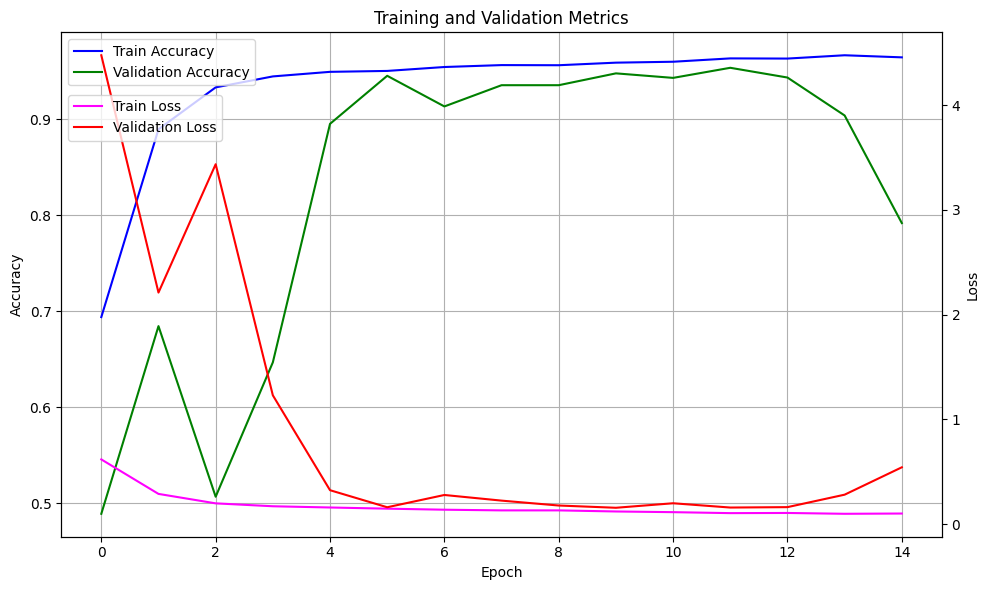

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Convert the history dictionary to a DataFrame
df = pd.DataFrame(data=history.history)
display(df)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation accuracy on the primary y-axis
ax1.plot(df['binary_accuracy'], label='Train Accuracy', color='blue')
ax1.plot(df['val_binary_accuracy'], label='Validation Accuracy', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left', bbox_to_anchor=(0., 1))

# Create a second y-axis to plot training and validation loss
ax2 = ax1.twinx()
ax2.plot(df['loss'], label='Train Loss', color='magenta')
ax2.plot(df['val_loss'], label='Validation Loss', color='red')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left', bbox_to_anchor=(0., 0.89))

# Add grid and title
ax1.grid(True, 'both')
plt.title('Training and Validation Metrics')

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


In [14]:
# Save the model in the native Keras format
model.save('/tf/projects/malaria-image-recognition/notebooks/cnn_malaria_image_model_batch_300.keras')